In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import keras
import keras.preprocessing.image
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.preprocessing.csv_generator import CSVGenerator

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


In [2]:
model = keras.models.load_model('../snapshots/resnet50_csv_14.h5', custom_objects=custom_objects)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu

c:\programdata\anaconda3\lib\site-packages\keras-2.1.2-py3.6.egg\keras\models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [3]:
# create image data generator object
val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

# create a generator for testing data
validation_generator = CSVGenerator(
                'C:\\Users\\Kai\\study\\robot_prototype\\data\\MLRotation\\annotation2.txt',
                'C:\\Users\\Kai\\study\\robot_prototype\\data\\MLRotation\\classname2.txt',
                val_image_data_generator,
                batch_size=1000
            )

In [24]:
# load image
index = np.random.randint(0,16800)
image = validation_generator.load_image(index)

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = validation_generator.preprocess_image(image)
image, scale = validation_generator.resize_image(image)
annotations = validation_generator.load_annotations(index)

print(index)
print(validation_generator.image_path(index))
print(scale)
print(annotations)


14935
C:\Users\Kai\study\robot_prototype\data\MLRotation\resultImg/out_110_-160_5.png
1.0033444816053512
[[ 546.  496.  646.  596.    7.]]


In [25]:
# process image
start = time.time()
_, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]
# correct for image scale
detections[0, :, :4] /= scale

processing time:  0.7193458080291748


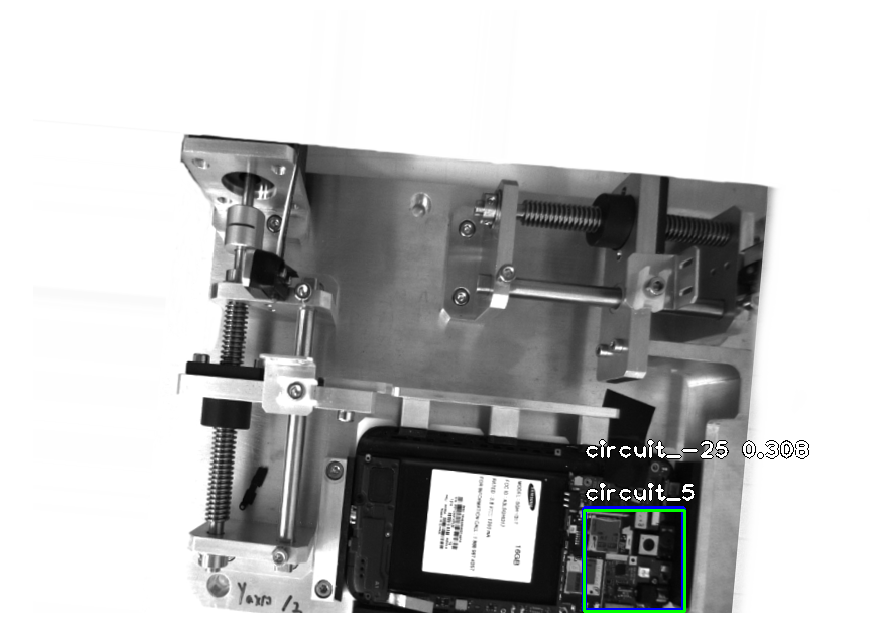

In [26]:
# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.2:
        continue
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
    caption = "{} {:.3f}".format(validation_generator.label_to_name(label), score)
    cv2.putText(draw, caption, (b[0], b[1] - 50), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 50), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
# visualize annotations
for annotation in annotations:
    label = int(annotation[4])
    b = annotation[:4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
    caption = "{}".format(validation_generator.label_to_name(label))
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

In [ ]:
print(detections[0:3])

In [ ]:
print(scores[0:3])